# Image Segmenation on CityScapes Dataset

This PyTorch script aims to train a SegmentationModel task using the CityScapes dataset, with all required files pre-uploaded on Google Drive as a zip file. The code covers essential tasks such as dataset extraction, data loading, and model training, utilizing the DeepLabV3Plus architecture with a resnet34 encoder.

> The segmentation steps are given below:<br>


1.   Data Prepration
2.   Data Transformation
3.   Custom Dataset Class
4.   Segmentation Model
5.   Training and Evaluation Functions
6.   Training Loop
7.   Model Evaluation



Before Starting with the Project we need to collect data from Google Drive

### Mounting Google Drive and Installing Dependencies:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=597360ffad2b4afe21d38fa9b6e0c8386897bd9acb7f64a020ca41744f7a2c1d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=4abc7257e505b0b6a9d1f0ba7a387ba679c1913073d7555853bd9dc54bf8683b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


In [3]:
import os
import glob
import torch
import zipfile
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import albumentations as A
from typing import Any, Tuple
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
import segmentation_models_pytorch as smp
from torchvision.datasets import Cityscapes
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from segmentation_models_pytorch.losses import DiceLoss

###1. Data Prepration
* CityScapes dataset is extracted from a zip file.
* Parameters such as the number of epochs, learning rate, encoder type, device, batch size, and image size are set.

In [4]:
zip_ref= zipfile.ZipFile("/content/drive/MyDrive/CityScapes.zip",'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

In [5]:
cityscapes = '/content/dataset/CityScapes/'
os.listdir(cityscapes)

['leftImg8bit', 'gtFine']

In [6]:
Epochs = 20
learning_rate = 0.0001
encoder = 'resnet34'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 4
img_size = (256,512)

#### Semantic Segmentation Configuration

In [7]:
ignore_index = 255
void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
target_classes = [ignore_index, 7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
class_labels = ['unlabeled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light', \
                'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', \
                'train', 'motorcycle', 'bicycle']

class_label_mapping = dict(zip(target_classes, range(len(target_classes))))
num_classes = len(target_classes)

In [8]:
colors = [   [  0,   0,   0],
        [128, 64, 128],
        [244, 35, 232],
        [70, 70, 70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170, 30],
        [220, 220, 0],
        [107, 142, 35],
        [152, 251, 152],
        [70, 130, 180],
        [220, 20, 60],
        [255, 0, 0],
        [0, 0, 142],
        [0, 0, 70],
        [0, 60, 100],
        [0, 80, 100],
        [0, 0, 230],
        [119, 11, 32],
    ]

label_colors = dict(zip(range(num_classes), colors))

In [9]:
def encode_segmap(mask):
    for void_class in void_classes:
        mask[mask == void_class] = ignore_index
    for valid_class in target_classes:
        mask[mask == valid_class] = class_label_mapping[valid_class]
    return mask

In [10]:
def decode_segmap(segmentation_map):
    rgb = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8)
    for label, color in label_colors.items():
        rgb[segmentation_map == label] = color
    return rgb / 255.0

### 2. Data Transformation

In [11]:
transform=A.Compose([
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
    ])

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

### 3. Custom Dataset Class
* A custom dataset class (CustomDataset) is defined, which inherits from torch.
utils.data.Dataset.
* The class handles loading and transforming images and masks.

In [12]:
class CustomClass(Cityscapes):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:

        image = Image.open(self.images[index]).convert('RGB')
        targets = [self._load_json(target) if t == 'polygon' else Image.open(target)
                   for t, target in zip(self.target_type, self.targets[index])]
        target = tuple(targets) if len(targets) > 1 else targets[0]

        if self.transforms:
            transformed = transform(image=np.array(image), mask=np.array(target))
            return transformed['image'], transformed['mask']

        return image, target

    def __len__(self):
        return len(self.images)

In [13]:
trainset = CustomClass(cityscapes, split='train', mode='fine', target_type='semantic',transforms=transform)
validset = CustomClass(cityscapes, split='val', mode='fine', target_type='semantic',transforms=transform)

In [14]:
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(validset, batch_size=batch_size, shuffle=False)

### 4. Segmentation Model
* The segmentation model is defined as a class (SegmentationModel) inheriting from torch.nn.Module.
* The model uses the DeepLabV3Plus architecture from the segmentation models library, with a specified encoder and activation function.

In [15]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.layer = smp.DeepLabV3Plus(
        encoder_name = encoder,
        encoder_weights="imagenet",
        in_channels= 3,
        classes=num_classes,
        activation=None
    )
    self.activation = nn.Sigmoid()
  def forward(self,x):
    return self.layer(x)

In [16]:
model = SegmentationModel()
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 103MB/s]


### 5. Training and Evaluation Functions:
* Functions for training (train_fn) and evaluation (eval_fn) are defined.
* Training involves iterating through batches, calculating and backpropagating the loss, and updating the model parameters.
*Evaluation is similar but without backpropagation.

In [17]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    for images, masks in tqdm(data_loader):
        images = images.to(device)
        segment = masks.to(device)

        optimizer.zero_grad()
        out = model(images)
        segment = encode_segmap(segment)
        loss = criterion(out, segment.long())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

In [18]:
def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(device)
            segment = masks.to(device)

            out = model(images)
            segment = encode_segmap(segment)
            loss = criterion(out, segment.long())

            total_loss += loss.item()

    return total_loss / len(data_loader)

### 6. Training Loop
* The main training loop runs for the specified number of epochs.
* Training and validation losses are recorded for each epoch.
* The model with the best validation loss is saved.

In [19]:
criterion= smp.losses.DiceLoss(mode='multiclass')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

best_valid_loss = np.Inf
train_losses = []
valid_losses = []

for i in range(Epochs):
    print(f"Epoch: {i+1}")

    train_loss = train_fn(train_loader, model, optimizer)
    valid_loss = eval_fn(val_loader, model)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f"Train Loss: {train_loss:.4f} Valid Loss: {valid_loss:.4f}")

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'road_scene_ImgSeg_model.pt')
        print('Model Saved!')
        best_valid_loss = valid_loss
    print('\n')

Epoch: 1


100%|██████████| 125/125 [01:03<00:00,  1.96it/s]


Train Loss: 0.5760 Valid Loss: 0.5046
Model Saved!


Epoch: 2


100%|██████████| 125/125 [00:58<00:00,  2.14it/s]


Train Loss: 0.4602 Valid Loss: 0.4346
Model Saved!


Epoch: 3


100%|██████████| 125/125 [01:00<00:00,  2.08it/s]


Train Loss: 0.4062 Valid Loss: 0.4172
Model Saved!


Epoch: 4


100%|██████████| 125/125 [01:02<00:00,  2.01it/s]


Train Loss: 0.3799 Valid Loss: 0.3970
Model Saved!


Epoch: 5


100%|██████████| 125/125 [01:00<00:00,  2.05it/s]


Train Loss: 0.3626 Valid Loss: 0.3931
Model Saved!


Epoch: 6


100%|██████████| 125/125 [00:59<00:00,  2.10it/s]


Train Loss: 0.3511 Valid Loss: 0.3795
Model Saved!


Epoch: 7


100%|██████████| 125/125 [01:00<00:00,  2.07it/s]


Train Loss: 0.3354 Valid Loss: 0.3769
Model Saved!


Epoch: 8


100%|██████████| 125/125 [01:03<00:00,  1.98it/s]


Train Loss: 0.3241 Valid Loss: 0.3670
Model Saved!


Epoch: 9


100%|██████████| 125/125 [00:58<00:00,  2.12it/s]


Train Loss: 0.3213 Valid Loss: 0.3667
Model Saved!


Epoch: 10


100%|██████████| 125/125 [00:58<00:00,  2.13it/s]


Train Loss: 0.3139 Valid Loss: 0.3765


Epoch: 11


100%|██████████| 125/125 [00:58<00:00,  2.14it/s]


Train Loss: 0.3058 Valid Loss: 0.3669


Epoch: 12


100%|██████████| 125/125 [00:59<00:00,  2.12it/s]


Train Loss: 0.2964 Valid Loss: 0.3649
Model Saved!


Epoch: 13


100%|██████████| 125/125 [00:57<00:00,  2.18it/s]


Train Loss: 0.2898 Valid Loss: 0.3636
Model Saved!


Epoch: 14


100%|██████████| 125/125 [00:57<00:00,  2.17it/s]


Train Loss: 0.2900 Valid Loss: 0.3651


Epoch: 15


100%|██████████| 125/125 [00:58<00:00,  2.15it/s]


Train Loss: 0.2847 Valid Loss: 0.3591
Model Saved!


Epoch: 16


100%|██████████| 125/125 [00:58<00:00,  2.14it/s]


Train Loss: 0.2801 Valid Loss: 0.3571
Model Saved!


Epoch: 17


100%|██████████| 125/125 [00:57<00:00,  2.19it/s]


Train Loss: 0.2773 Valid Loss: 0.3589


Epoch: 18


100%|██████████| 125/125 [00:58<00:00,  2.13it/s]


Train Loss: 0.2729 Valid Loss: 0.3593


Epoch: 19


100%|██████████| 125/125 [00:56<00:00,  2.19it/s]


Train Loss: 0.2689 Valid Loss: 0.3612


Epoch: 20


100%|██████████| 125/125 [00:57<00:00,  2.16it/s]


Train Loss: 0.2673 Valid Loss: 0.3566
Model Saved!




### Plot the training loss

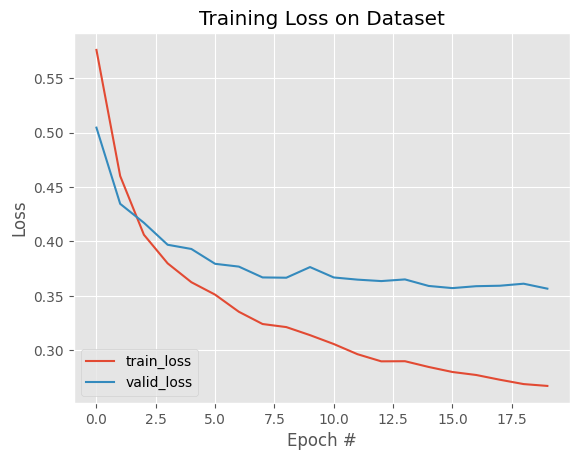

In [20]:
plt.style.use("ggplot")
plt.figure()
plt.plot(train_losses, label="train_loss")
plt.plot(valid_losses, label="valid_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

### 7. Model Evaluation

In [21]:
model.load_state_dict(torch.load('road_scene_ImgSeg_model.pt'))

<All keys matched successfully>

In [22]:
testset = CustomClass(cityscapes, split='val', mode='fine', target_type='semantic',transforms=transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [23]:
model=model.cuda()
model.eval()
with torch.no_grad():
    for batch in test_loader:
        img,seg=batch
        output=model(img.cuda())
        break

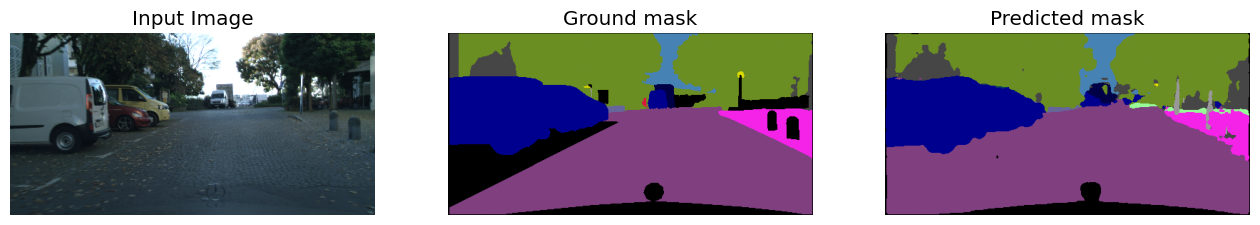

In [24]:
sample = 0
invimg = inv_normalize(img[sample])
outputx = output.detach().cpu()[sample]

invimg = np.clip(invimg, 0, 1)
decoded_mask = decode_segmap(encode_segmap(seg[sample].clone()))
decoded_output = decode_segmap(torch.argmax(outputx, 0))

fig, ax = plt.subplots(ncols=3, figsize=(16, 50), facecolor='white')
ax[0].imshow(np.moveaxis(invimg.numpy(), 0, 2))
ax[0].axis('off')
ax[1].imshow(decoded_mask)
ax[1].axis('off')
ax[2].imshow(decoded_output)
ax[2].axis('off')

ax[0].set_title('Input Image')
ax[1].set_title('Ground mask')
ax[2].set_title('Predicted mask')

plt.savefig('result.png', bbox_inches='tight')